## Quick Ptycho Notebook for Zvonimír

In [1]:
import numpy as np
import py4DSTEM

from scipy.io import loadmat

### Load data & calibrations

In [2]:
matlab_file = loadmat("data/rawdata_1x_crop.mat")
raw_data = matlab_file['cbed'].transpose((3,2,1,0)) # matlab ordering
raw_data = raw_data.clip(20) - 20 # EMPAD background

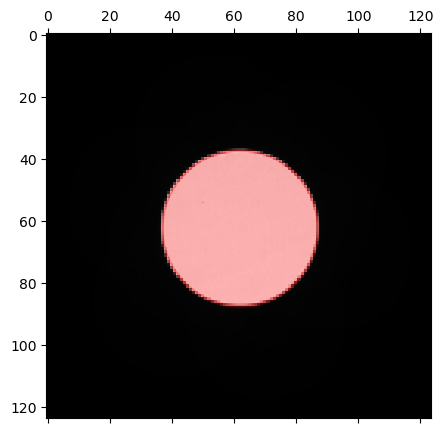

In [3]:
dataset = py4DSTEM.DataCube(raw_data)

dataset.get_dp_mean()
probe_radius_pixels, probe_qx0, probe_qy0 = dataset.get_probe_size(plot=True)

In [4]:
dataset.calibration.set_R_pixel_size(0.85)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(21.4 / probe_radius_pixels)
dataset.calibration.set_Q_pixel_units('mrad')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.8520626675778913
             R_pixel_size:      0.85
             Q_pixel_units:     mrad
             R_pixel_units:     A
             QR_flip:           False
             probe_semiangle:   25.11552355747791
             qx0_mean:          62.3559607060069
             qy0_mean:          61.88695614539022
)

### Parallax to estimate defocus & rotation

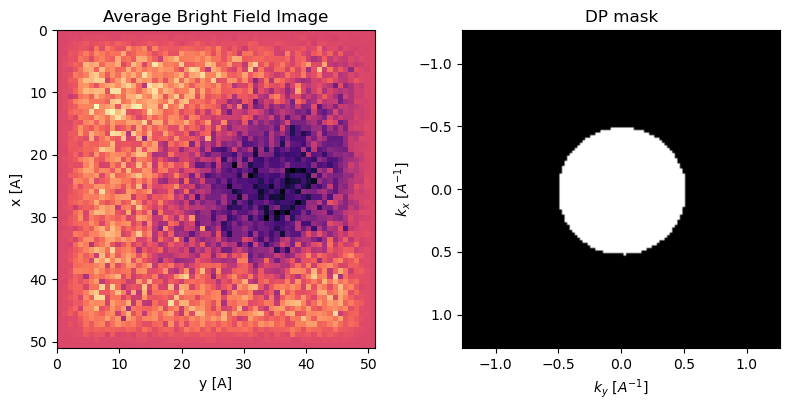

In [6]:
parallax = py4DSTEM.process.phase.ParallaxReconstruction(
    datacube=dataset,
    energy = 80e3,
    object_padding_px=(16,16),
    device = "gpu",
    verbose=True,
).preprocess(
    normalize_images=True,
    plot_average_bf=True,
    edge_blend=8,
)

Alignment at bin 8: 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 246.99 image subsets/s]


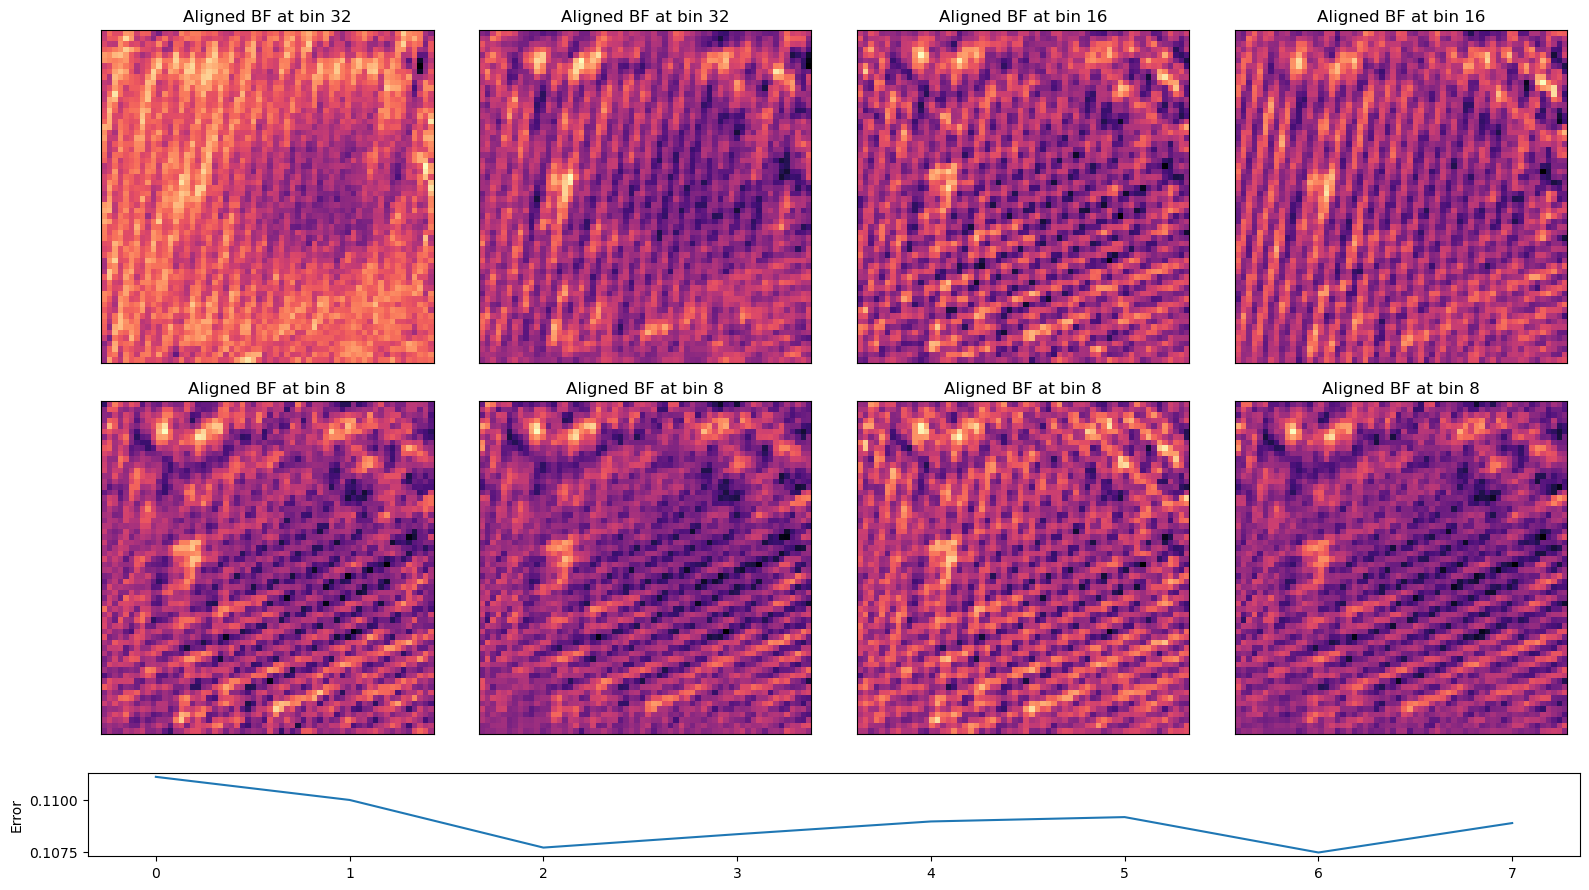

In [7]:
parallax = parallax.reconstruct(
    reset=True,
    regularizer_matrix_size=(2,2),
    regularize_shifts=True,
    running_average=True,
    alignment_bin_values = [32,32,16,16,8,8,8,8]
)

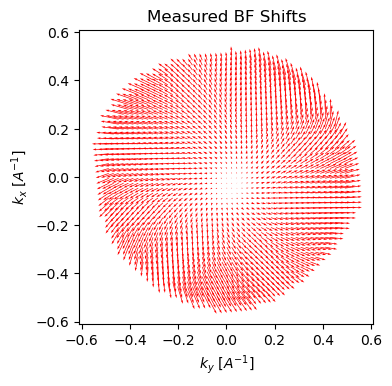

In [8]:
parallax.show_shifts(scale_arrows=0.25)

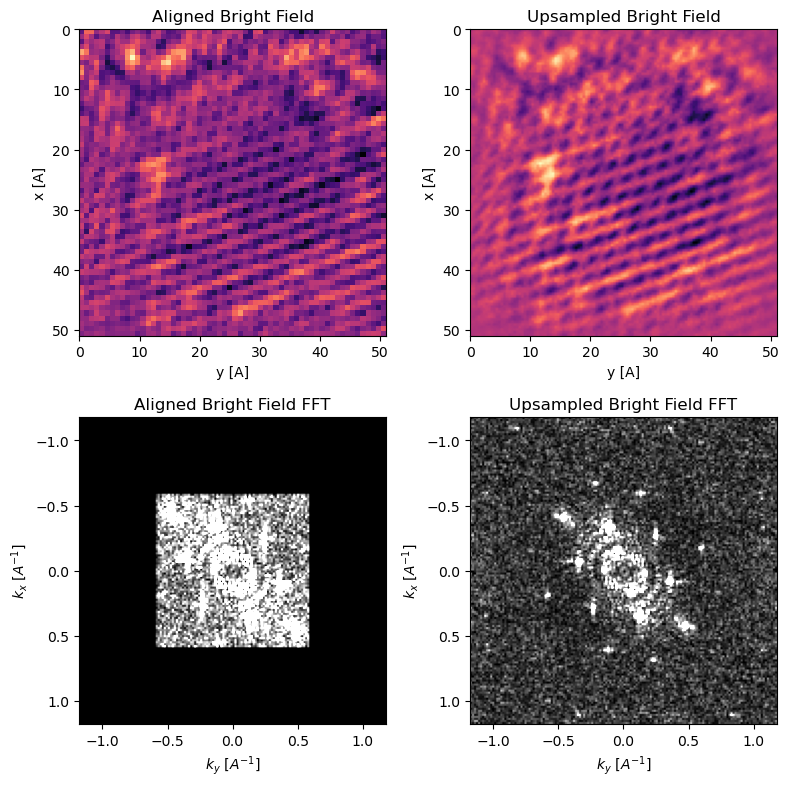

In [9]:
parallax.subpixel_alignment(
    kde_upsample_factor=2,
    kde_sigma_px=0.125,
    plot_upsampled_BF_comparison=True,
    plot_upsampled_FFT_comparison=True,
)

Rotation of Q w.r.t. R = -26.802 deg
Astigmatism (A1x,A1y)  = (5,-27) Ang
Aberration C1          =  471 Ang
Defocus dF             = -471 Ang
Transpose              = False


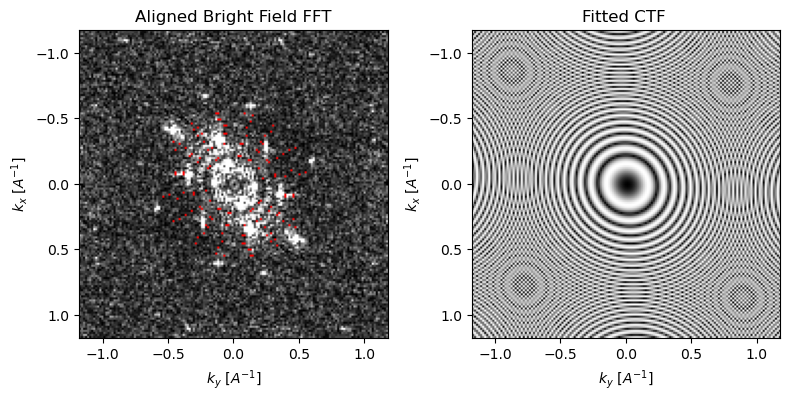

In [10]:
parallax.aberration_fit(
    plot_CTF_comparison=True,
)

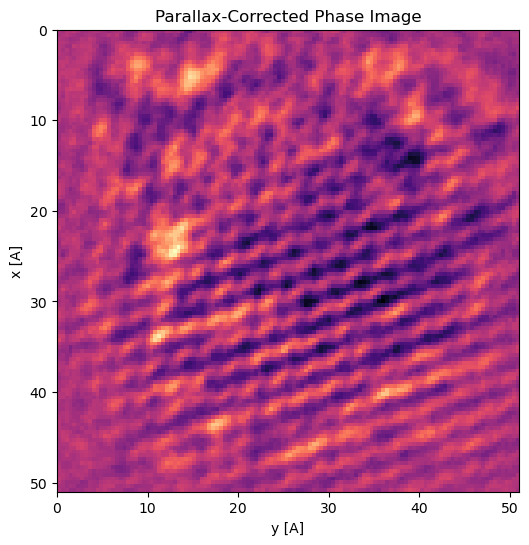

In [11]:
parallax.aberration_correct()

printing the two parameters you'll need below, in-case you don't have the latest `phase_contrast` branch version w/ the necessary parallax features, so you can manually enter them

In [12]:
parallax.aberration_dict_polar

{'C10': 471.05497357974065,
 'C12': 27.384033592394278,
 'phi12': -0.702778597294187,
 'C21': 0.0,
 'phi21': 0.0,
 'C23': 0.0,
 'phi23': 0.0}

In [13]:
np.rad2deg(parallax.rotation_Q_to_R_rads)

-26.801951252796176

## Single-slice ptycho

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:692: UserWarning: Best fit rotation forced to -27 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:706: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


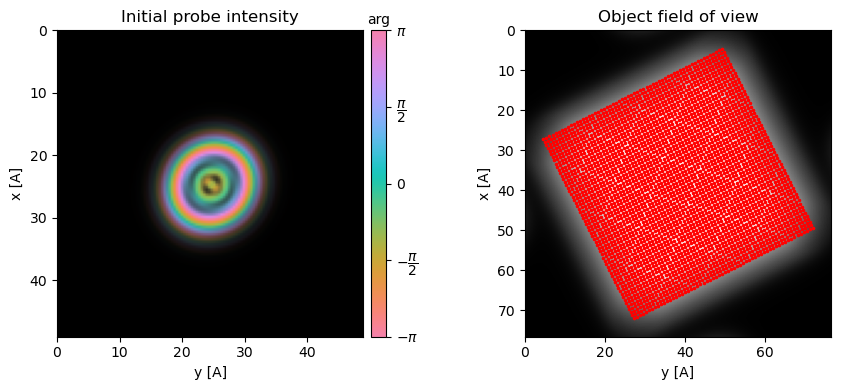

In [14]:
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dataset,
    device = 'gpu',
    energy = 80e3,
    semiangle_cutoff = 21.4,
    object_padding_px=(12,12),
    polar_parameters=parallax.aberration_dict_polar,
).preprocess(
    plot_center_of_mass = False, 
    plot_probe_overlaps = True, 
    force_com_rotation = np.rad2deg(parallax.rotation_Q_to_R_rads), 
    force_com_transpose = False,
)

Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: None, in batches of max 0.5 measurements.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.30 iter/s]


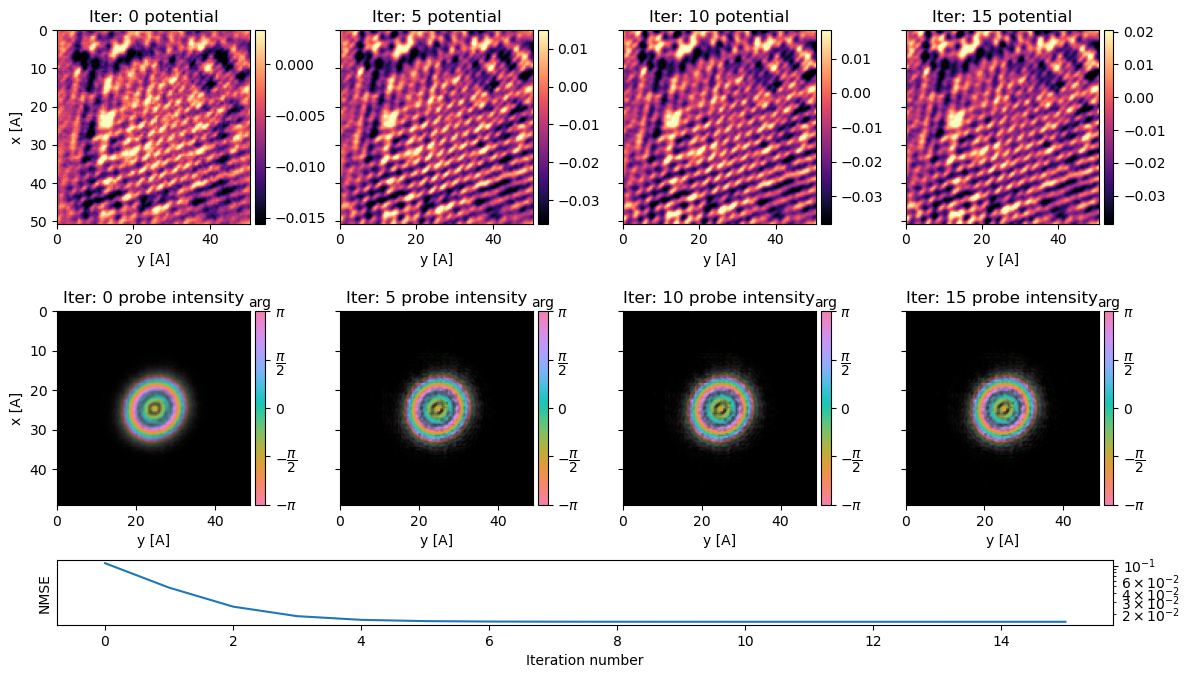

In [15]:
ptycho = ptycho.reconstruct(
    reset = True,
    store_iterations = True,
    max_iter = 16,
    step_size = 0.5,
    q_lowpass = 1.25, # A^-1
).visualize(
    iterations_grid='auto',
)

## Mixed-state ptycho

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:692: UserWarning: Best fit rotation forced to -27 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:706: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


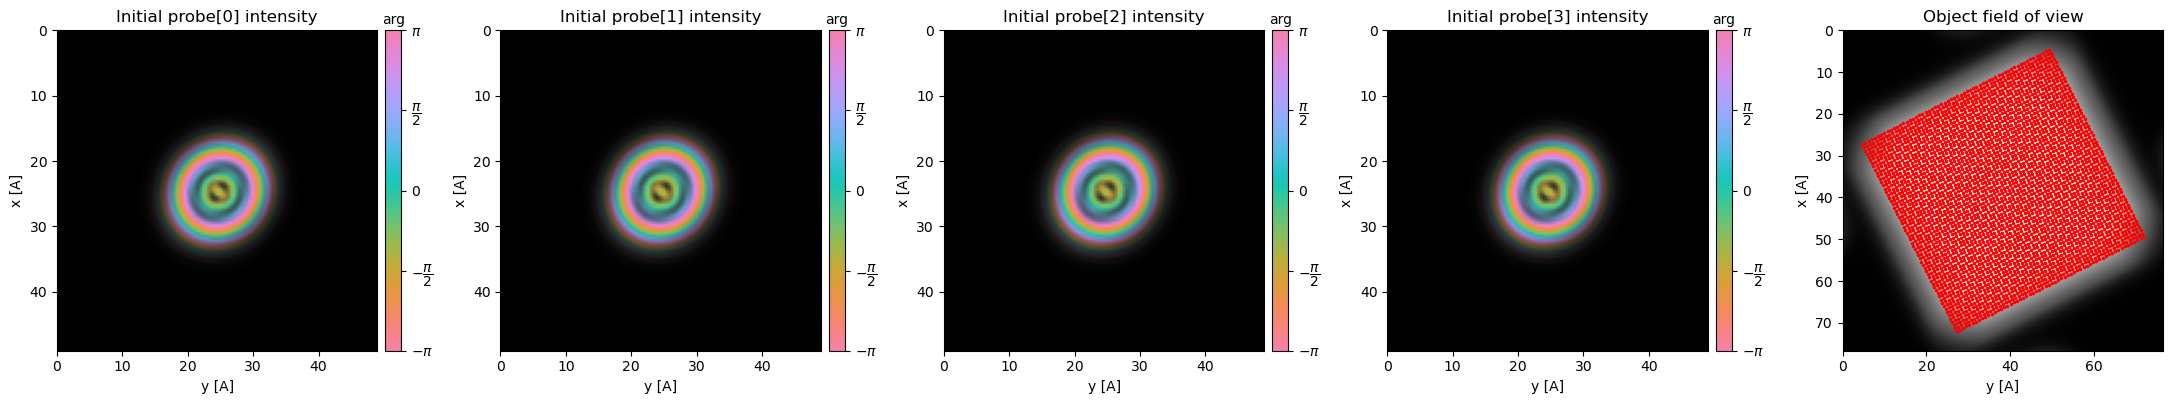

In [16]:
ptycho_mix = py4DSTEM.process.phase.MixedstatePtychographicReconstruction(
    datacube=dataset,
    num_probes=4,
    device = 'gpu',
    energy = 80e3,
    semiangle_cutoff = 21.4,
    object_padding_px=(12,12),
    polar_parameters=parallax.aberration_dict_polar,
).preprocess(
    plot_center_of_mass = False, 
    plot_probe_overlaps = True, 
    force_com_rotation = np.rad2deg(parallax.rotation_Q_to_R_rads), 
    force_com_transpose = False,
)

Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 6, in batches of max 0.5 measurements.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 64/64 [07:50<00:00,  7.36s/ iter]


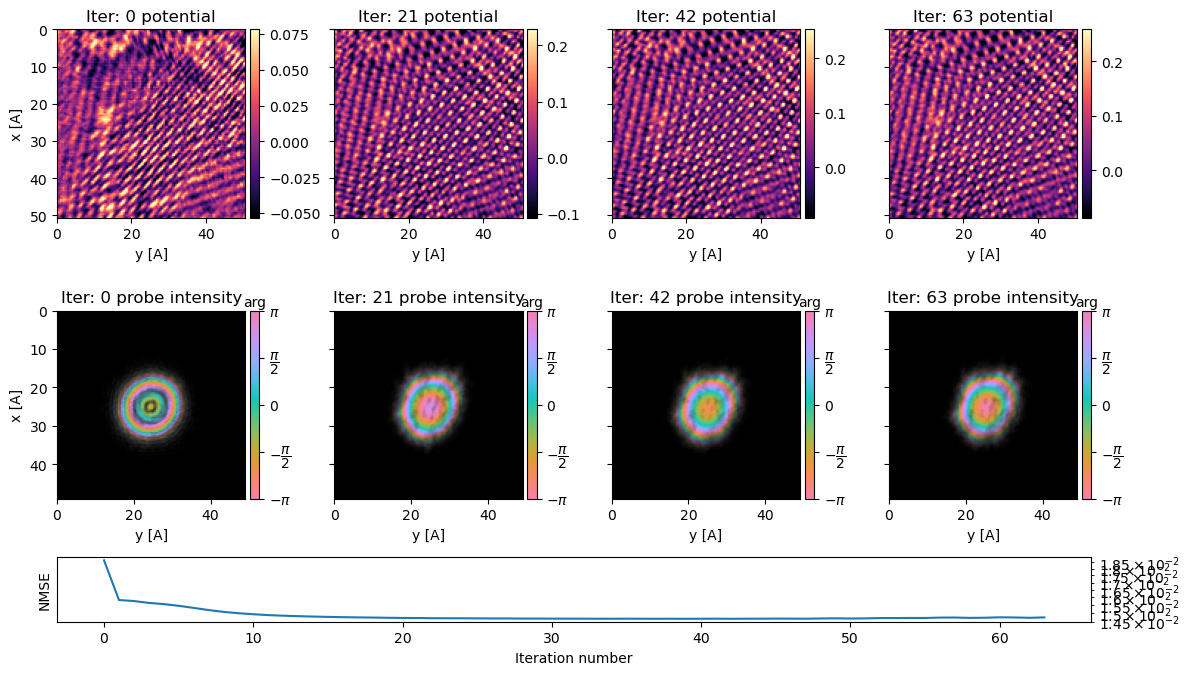

In [17]:
ptycho_mix = ptycho_mix.reconstruct(
    reset = True,
    store_iterations = True,
    max_iter = 64,
    step_size = 0.5,
    q_lowpass = 1.25, # A^-1
    max_batch_size= 6,# important this is small for mixed-state
).visualize(
    iterations_grid='auto',
)

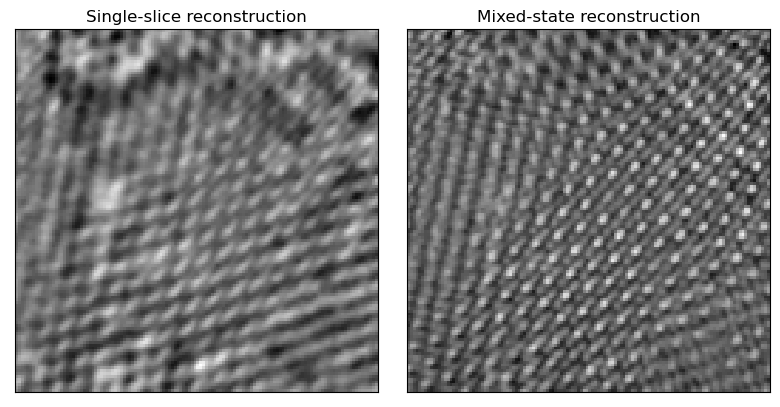

In [18]:
py4DSTEM.show(
    [
        np.angle(ptycho.object_cropped),
        np.angle(ptycho_mix.object_cropped),
    ],
    title=["Single-slice reconstruction","Mixed-state reconstruction"],
    axsize=(4,4),
    vmin=0,vmax=1,ticks=False,
)

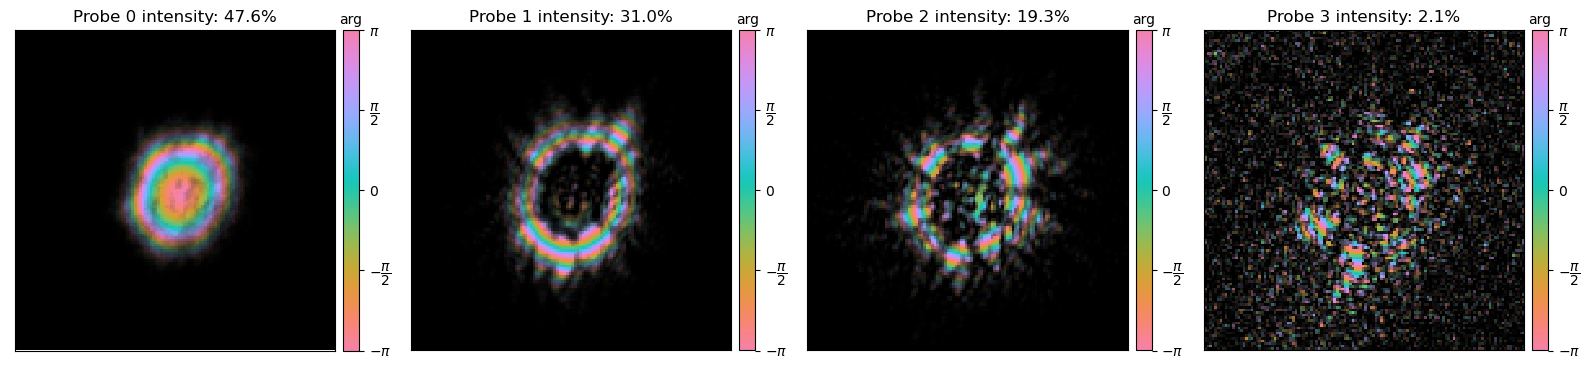

In [20]:
intensity_arrays = np.array([np.abs(probe)**2 for probe in ptycho_mix.probe])
probe_ratio      = [np.sum(intensity_array)/intensity_arrays.sum() for intensity_array in intensity_arrays]
title            = [f"Probe {iter} intensity: {ratio*100:.1f}%" for iter, ratio in enumerate(probe_ratio)]

py4DSTEM.show_complex(
    list(ptycho_mix.probe),
    axsize=(4,4),
    ticks=False,
    power=2,
    title=title,
)